In [1]:
## @meermehran -- M3RG Lab -- Indian Institute of Technology, Delhi
## @date : 4July2022

####################################--DESCRIPTION####################################################
##                                                                                                 ##
## Using Fourier Neural Operator to predict the tensorial compoents of a stress and strain fields. ##
##                                                                                                 ##        
#####################################################################################################


In [2]:
## importing the necessary libraries

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utility import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


### Model Architecture

In [3]:
class FouirerLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(FouirerLayer, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, strain_channels):
        super(FNO2d, self).__init__()


        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.strain_channels  = strain_channels
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) ##input channels := [x y Material]

        self.conv0 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.strain_channels) ## output channels := [xx,yy,xy]

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

### Reading the Data:

In [4]:
##Loading data

path1 = '/home/civil/mtech/cey217538/GitHub/FNOStressStrain/material.mat'  
path2 = '/home/civil/mtech/cey217538/GitHub/FNOStressStrain/strainsv2.mat'  #strain file

material_dict = sio.loadmat(path1)
strains_dict = sio.loadmat(path2)

material = material_dict['Emat'].astype(np.float32)
strains = strains_dict['strains'].astype(np.float32)


## convert to Tensors
material = torch.from_numpy(material)
strains = torch.from_numpy(strains)

## Train and Test samples
ntrain = 1500
ntest = 200


## Train and Test Split

## X - Input - Material Geometry
x_train = material[:2*ntrain:2]
x_test =  material[-ntest:] 

## Y - Output - Strains [xx, yy, xy] -- 3 dimensional
y_train = strains[:2*ntrain:2]
y_test = strains[-ntest:]

test_geo =material[-ntest:]


In [5]:
## hyp par settings

batch_size = 20
learning_rate = 0.01
step_size = 100
epochs = 300
gamma = 0.5
modes =12
width = 32

In [6]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

dim = 48 # image resolution

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([1500, 48, 48, 1]) torch.Size([1500, 48, 48, 3]) torch.Size([200, 48, 48, 1]) torch.Size([200, 48, 48, 3])


In [7]:
strain_channels = 3
model = FNO2d(modes, modes, width, strain_channels).cuda()
print(f'MODEL PARAMETERS. :== {count_params(model)}')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


MODEL PARAMETERS. :== 1188611


### Training--STRAIN MODEL

In [8]:

myloss = L2Loss(size_average=False)
y_normalizer.cuda()

## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 7.9913 || TrainError:== 0.350925  ||  TestError:== 0.217995
 Epoch :== 2  ||  TIME(sec):== 1.4101 || TrainError:== 0.18432  ||  TestError:== 0.168914
 Epoch :== 3  ||  TIME(sec):== 1.4128 || TrainError:== 0.153847  ||  TestError:== 0.152535
 Epoch :== 4  ||  TIME(sec):== 1.4153 || TrainError:== 0.135319  ||  TestError:== 0.140093
 Epoch :== 5  ||  TIME(sec):== 1.4149 || TrainError:== 0.125926  ||  TestError:== 0.139063
 Epoch :== 6  ||  TIME(sec):== 1.4153 || TrainError:== 0.121228  ||  TestError:== 0.128347
 Epoch :== 7  ||  TIME(sec):== 1.4104 || TrainError:== 0.1114  ||  TestError:== 0.124149
 Epoch :== 8  ||  TIME(sec):== 1.4224 || TrainError:== 0.108548  ||  TestError:== 0.118425
 Epoch :== 9  ||  TIME(sec):== 1.4131 || TrainError:== 0.104178  ||  TestError:== 0.115147
 Epoch :== 10  ||  TIME(sec):== 1.4129 || TrainError:== 0.103069  ||  TestError:== 0.109688
 Epoch :== 11  ||  TIME(sec):== 1.4175 || TrainError:== 0.098711  ||  TestError:== 0.111785


 Epoch :== 91  ||  TIME(sec):== 1.4199 || TrainError:== 0.065625  ||  TestError:== 0.084565
 Epoch :== 92  ||  TIME(sec):== 1.4108 || TrainError:== 0.067614  ||  TestError:== 0.086082
 Epoch :== 93  ||  TIME(sec):== 1.4135 || TrainError:== 0.069023  ||  TestError:== 0.082591
 Epoch :== 94  ||  TIME(sec):== 1.4075 || TrainError:== 0.067842  ||  TestError:== 0.082965
 Epoch :== 95  ||  TIME(sec):== 1.4113 || TrainError:== 0.065495  ||  TestError:== 0.086326
 Epoch :== 96  ||  TIME(sec):== 1.4102 || TrainError:== 0.066806  ||  TestError:== 0.086495
 Epoch :== 97  ||  TIME(sec):== 1.4035 || TrainError:== 0.066486  ||  TestError:== 0.089054
 Epoch :== 98  ||  TIME(sec):== 1.3979 || TrainError:== 0.066923  ||  TestError:== 0.084911
 Epoch :== 99  ||  TIME(sec):== 1.3936 || TrainError:== 0.066653  ||  TestError:== 0.08605
 Epoch :== 100  ||  TIME(sec):== 1.3891 || TrainError:== 0.066794  ||  TestError:== 0.084556
 Epoch :== 101  ||  TIME(sec):== 1.4001 || TrainError:== 0.05621  ||  TestError:

 Epoch :== 180  ||  TIME(sec):== 1.4182 || TrainError:== 0.046737  ||  TestError:== 0.069621
 Epoch :== 181  ||  TIME(sec):== 1.416 || TrainError:== 0.047392  ||  TestError:== 0.071247
 Epoch :== 182  ||  TIME(sec):== 1.4145 || TrainError:== 0.047158  ||  TestError:== 0.070652
 Epoch :== 183  ||  TIME(sec):== 1.4058 || TrainError:== 0.047359  ||  TestError:== 0.070604
 Epoch :== 184  ||  TIME(sec):== 1.4012 || TrainError:== 0.047205  ||  TestError:== 0.06905
 Epoch :== 185  ||  TIME(sec):== 1.3947 || TrainError:== 0.04599  ||  TestError:== 0.070514
 Epoch :== 186  ||  TIME(sec):== 1.4096 || TrainError:== 0.046897  ||  TestError:== 0.068214
 Epoch :== 187  ||  TIME(sec):== 1.4248 || TrainError:== 0.0472  ||  TestError:== 0.070839
 Epoch :== 188  ||  TIME(sec):== 1.4186 || TrainError:== 0.047952  ||  TestError:== 0.072411
 Epoch :== 189  ||  TIME(sec):== 1.4084 || TrainError:== 0.048077  ||  TestError:== 0.06885
 Epoch :== 190  ||  TIME(sec):== 1.4021 || TrainError:== 0.047202  ||  TestE

 Epoch :== 269  ||  TIME(sec):== 1.4285 || TrainError:== 0.035842  ||  TestError:== 0.062631
 Epoch :== 270  ||  TIME(sec):== 1.4255 || TrainError:== 0.035043  ||  TestError:== 0.062818
 Epoch :== 271  ||  TIME(sec):== 1.4053 || TrainError:== 0.034632  ||  TestError:== 0.062607
 Epoch :== 272  ||  TIME(sec):== 1.4097 || TrainError:== 0.034785  ||  TestError:== 0.062555
 Epoch :== 273  ||  TIME(sec):== 1.4013 || TrainError:== 0.034645  ||  TestError:== 0.062103
 Epoch :== 274  ||  TIME(sec):== 1.4232 || TrainError:== 0.034541  ||  TestError:== 0.061978
 Epoch :== 275  ||  TIME(sec):== 1.4289 || TrainError:== 0.034089  ||  TestError:== 0.060813
 Epoch :== 276  ||  TIME(sec):== 1.4218 || TrainError:== 0.034178  ||  TestError:== 0.062194
 Epoch :== 277  ||  TIME(sec):== 1.4224 || TrainError:== 0.034396  ||  TestError:== 0.061367
 Epoch :== 278  ||  TIME(sec):== 1.422 || TrainError:== 0.034889  ||  TestError:== 0.062092
 Epoch :== 279  ||  TIME(sec):== 1.4239 || TrainError:== 0.034186  ||  

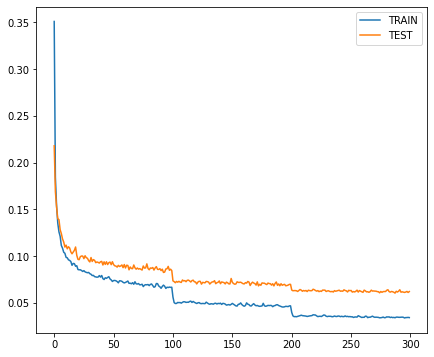

In [9]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [10]:
## testing

prediction = torch.zeros(y_test.shape).cuda()

counter = 0
print(f' TEST SET SHAPE :: {y_test.shape}')

with torch.no_grad():
    for x , y in test_loader:
      x,y = x.cuda(), y.cuda()
      out = model(x).reshape(batch_size,48,48,strain_channels)  #out.shape[batchsize, 48,48, channels]
      out = y_normalizer.decode(out)
      prediction[counter*batch_size: (counter*batch_size) + batch_size] = out
      counter+=1


 TEST SET SHAPE :: torch.Size([200, 48, 48, 3])


In [11]:
zpred = toNumpy(prediction)[0]
ytest = toNumpy(y_test)[0]
xcor,ycor = getgrid(x_train)   ## numpy arrays
xtest = toNumpy(test_geo)[0]

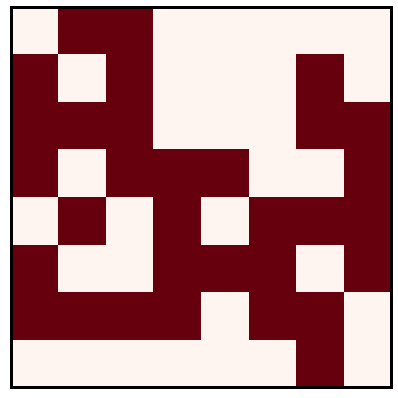

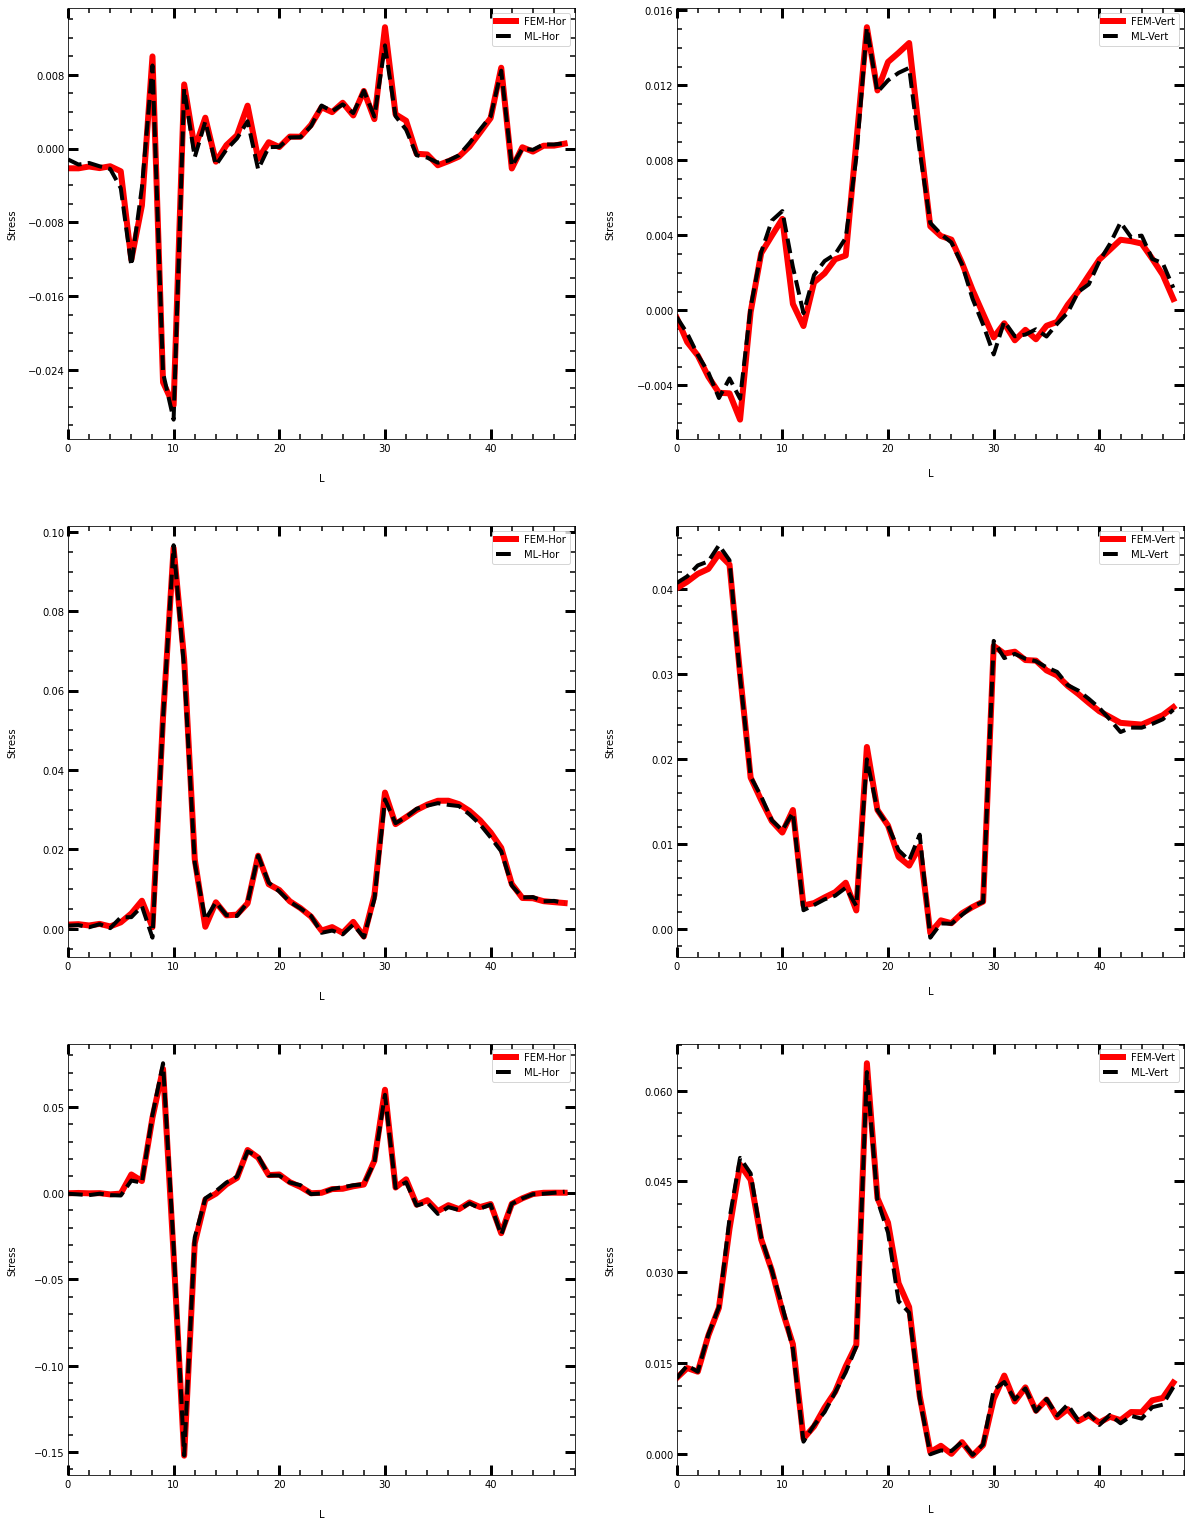

In [12]:
index=66

geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

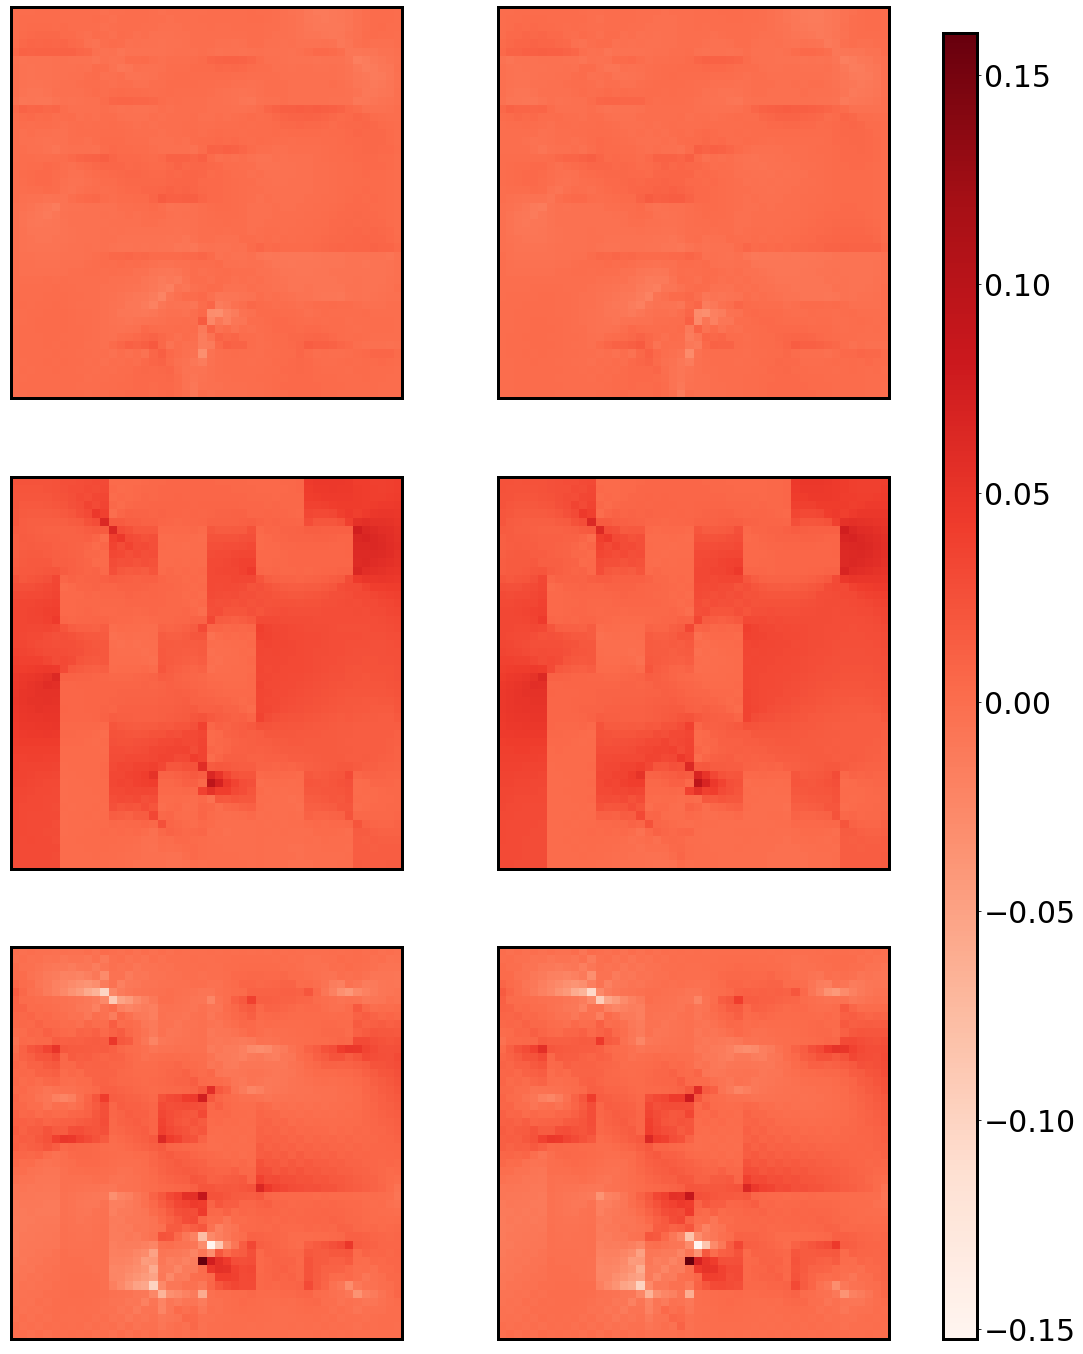

In [13]:
contour(ytest,zpred,xcor,ycor,index,cmap ='Reds')

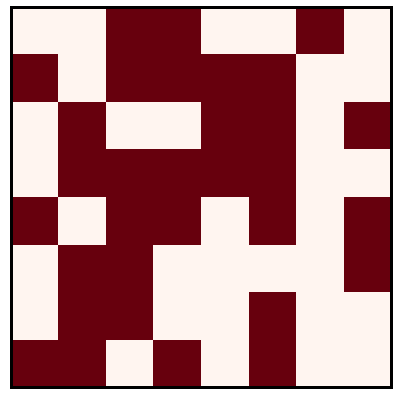

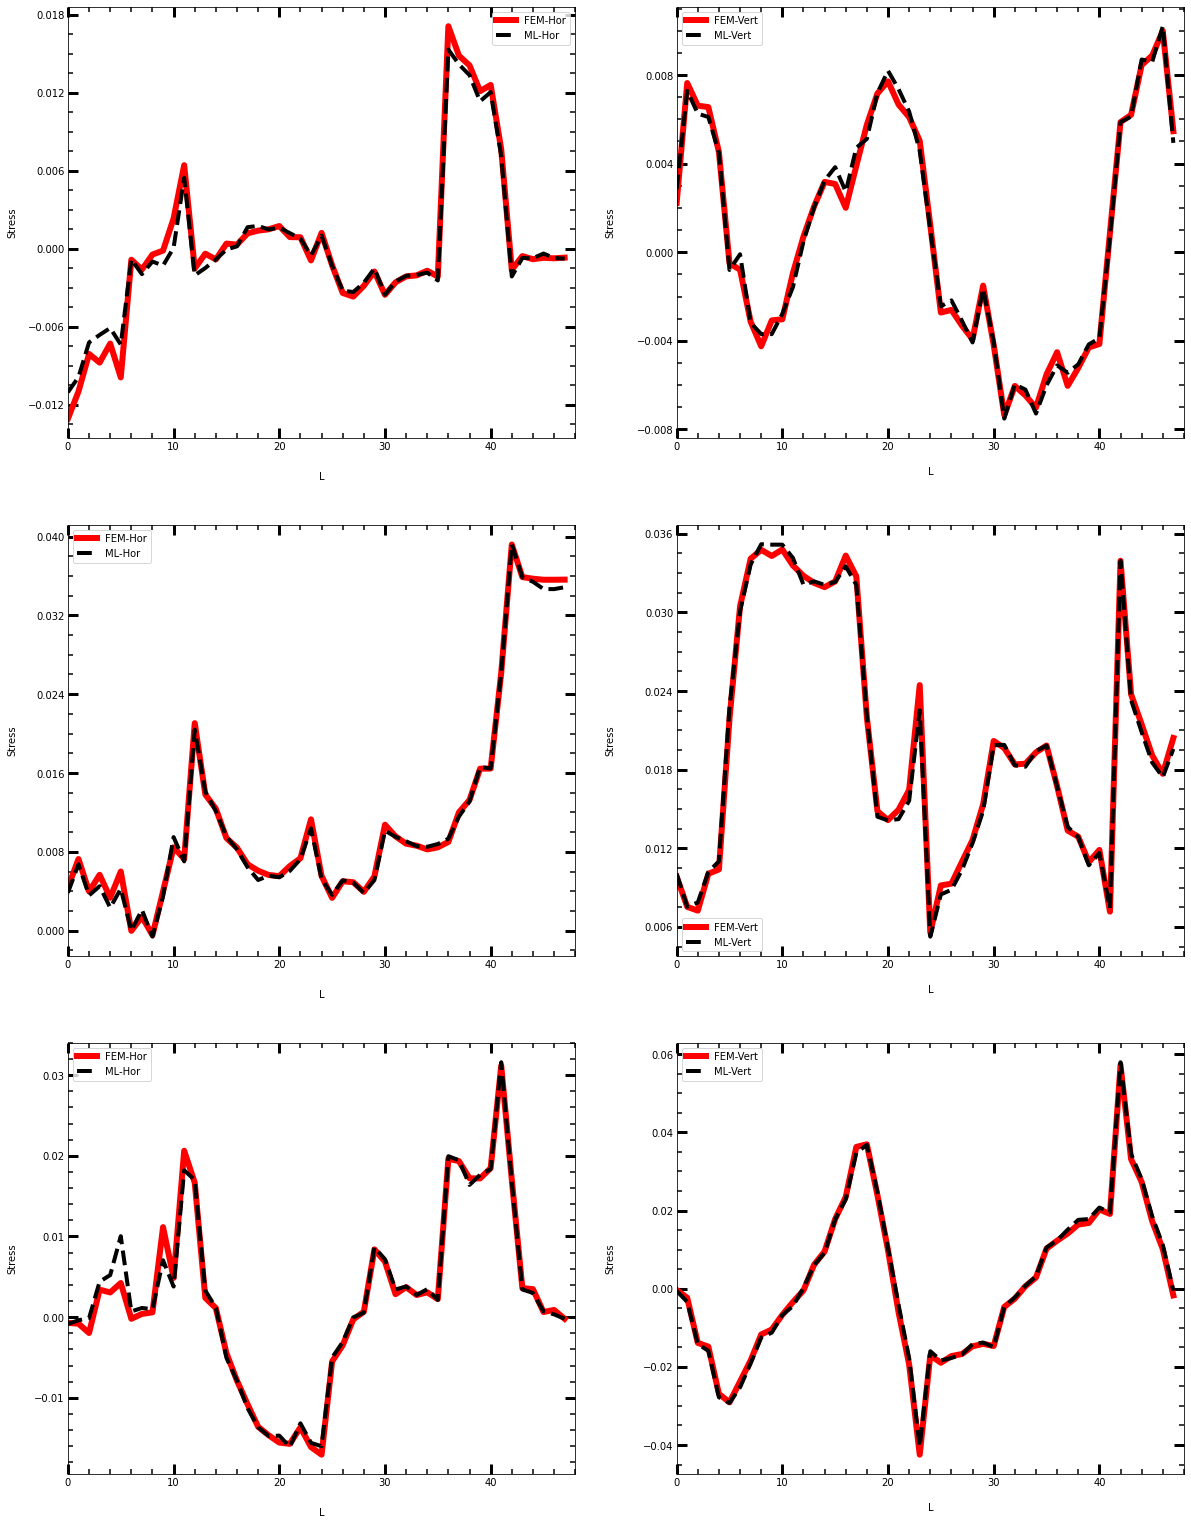

In [14]:
index=33

geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

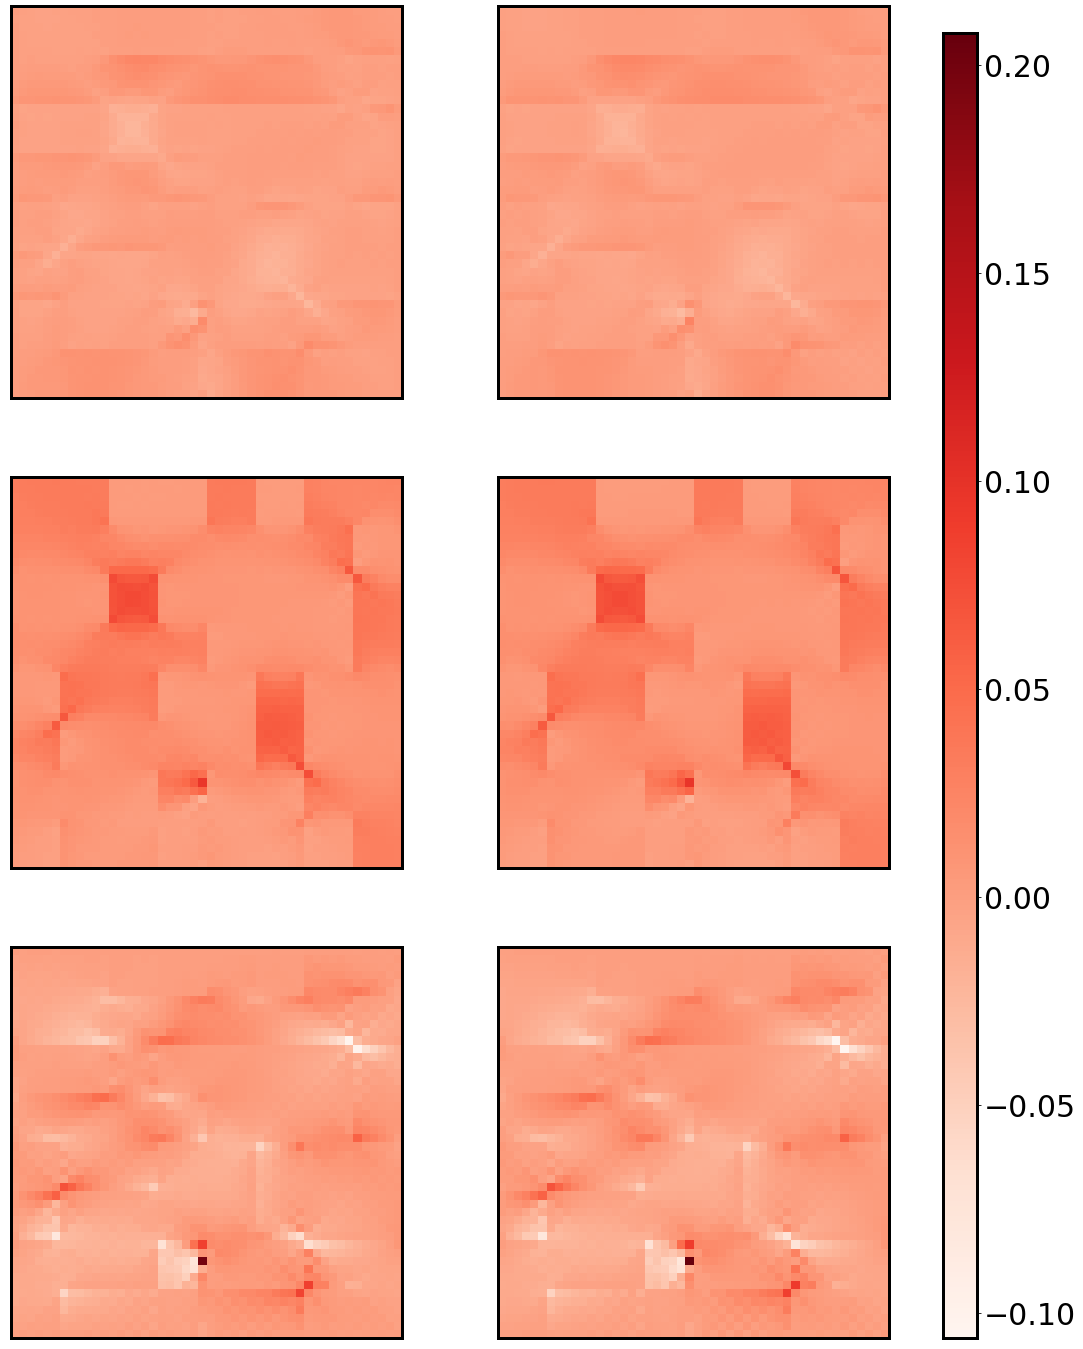

In [15]:
contour(ytest,zpred,xcor,ycor,index,cmap ='Reds')

# ----------------------------------------------------------------------------------------

### STRESSES


In [16]:
##Loading data

path1 = '/home/civil/mtech/cey217538/GitHub/FNOStressStrain/material.mat'  
path2 = '/home/civil/mtech/cey217538/GitHub/FNOStressStrain/stressesv2.mat'  #strain file

material_dict = sio.loadmat(path1)
strains_dict = sio.loadmat(path2)

material = material_dict['Emat'].astype(np.float32)
strains = strains_dict['stresses'].astype(np.float32)


## convert to Tensors
material = torch.from_numpy(material)
strains = torch.from_numpy(strains)

## Train and Test samples
ntrain = 1500
ntest = 200


## Train and Test Split

## X - Input - Material Geometry
x_train = material[:2*ntrain:2]
x_test =  material[-ntest:] 

## Y - Output - Strains [xx, yy, xy] -- 3 dimensional
y_train = strains[:2*ntrain:2]
y_test = strains[-ntest:]

test_geo =material[-ntest:]

In [17]:
## hyp par settings

batch_size = 20
learning_rate = 0.01
step_size = 100
epochs = 300
gamma = 0.5
modes =12
width = 32

In [18]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

dim = 48 # image resolution

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([1500, 48, 48, 1]) torch.Size([1500, 48, 48, 3]) torch.Size([200, 48, 48, 1]) torch.Size([200, 48, 48, 3])


In [19]:
strain_channels = 3
model = FNO2d(modes, modes, width, strain_channels).cuda()
print(f'MODEL PARAMETERS. :== {count_params(model)}')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

MODEL PARAMETERS. :== 1188611


In [20]:

myloss = L2Loss(size_average=False)
y_normalizer.cuda()

## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 1.4408 || TrainError:== 0.301799  ||  TestError:== 0.207855
 Epoch :== 2  ||  TIME(sec):== 1.4105 || TrainError:== 0.182953  ||  TestError:== 0.178203
 Epoch :== 3  ||  TIME(sec):== 1.4139 || TrainError:== 0.155127  ||  TestError:== 0.153384
 Epoch :== 4  ||  TIME(sec):== 1.4171 || TrainError:== 0.137705  ||  TestError:== 0.139939
 Epoch :== 5  ||  TIME(sec):== 1.421 || TrainError:== 0.129426  ||  TestError:== 0.139747
 Epoch :== 6  ||  TIME(sec):== 1.4156 || TrainError:== 0.123962  ||  TestError:== 0.134305
 Epoch :== 7  ||  TIME(sec):== 1.4184 || TrainError:== 0.120447  ||  TestError:== 0.13425
 Epoch :== 8  ||  TIME(sec):== 1.4157 || TrainError:== 0.11764  ||  TestError:== 0.128528
 Epoch :== 9  ||  TIME(sec):== 1.4168 || TrainError:== 0.114148  ||  TestError:== 0.131651
 Epoch :== 10  ||  TIME(sec):== 1.415 || TrainError:== 0.110093  ||  TestError:== 0.122472
 Epoch :== 11  ||  TIME(sec):== 1.4124 || TrainError:== 0.105396  ||  TestError:== 0.119929
 

 Epoch :== 91  ||  TIME(sec):== 1.4056 || TrainError:== 0.06932  ||  TestError:== 0.101306
 Epoch :== 92  ||  TIME(sec):== 1.4237 || TrainError:== 0.070387  ||  TestError:== 0.094594
 Epoch :== 93  ||  TIME(sec):== 1.4088 || TrainError:== 0.064997  ||  TestError:== 0.094393
 Epoch :== 94  ||  TIME(sec):== 1.4141 || TrainError:== 0.066095  ||  TestError:== 0.09091
 Epoch :== 95  ||  TIME(sec):== 1.4111 || TrainError:== 0.068183  ||  TestError:== 0.097881
 Epoch :== 96  ||  TIME(sec):== 1.4126 || TrainError:== 0.066673  ||  TestError:== 0.095698
 Epoch :== 97  ||  TIME(sec):== 1.4194 || TrainError:== 0.071291  ||  TestError:== 0.094463
 Epoch :== 98  ||  TIME(sec):== 1.4171 || TrainError:== 0.067743  ||  TestError:== 0.092644
 Epoch :== 99  ||  TIME(sec):== 1.4074 || TrainError:== 0.066057  ||  TestError:== 0.092499
 Epoch :== 100  ||  TIME(sec):== 1.4182 || TrainError:== 0.063051  ||  TestError:== 0.089992
 Epoch :== 101  ||  TIME(sec):== 1.4092 || TrainError:== 0.053904  ||  TestError:

 Epoch :== 180  ||  TIME(sec):== 1.4137 || TrainError:== 0.049393  ||  TestError:== 0.082458
 Epoch :== 181  ||  TIME(sec):== 1.4201 || TrainError:== 0.047156  ||  TestError:== 0.080214
 Epoch :== 182  ||  TIME(sec):== 1.4178 || TrainError:== 0.045176  ||  TestError:== 0.08003
 Epoch :== 183  ||  TIME(sec):== 1.419 || TrainError:== 0.045101  ||  TestError:== 0.081012
 Epoch :== 184  ||  TIME(sec):== 1.4111 || TrainError:== 0.045646  ||  TestError:== 0.081177
 Epoch :== 185  ||  TIME(sec):== 1.4069 || TrainError:== 0.045388  ||  TestError:== 0.079022
 Epoch :== 186  ||  TIME(sec):== 1.4121 || TrainError:== 0.045442  ||  TestError:== 0.079148
 Epoch :== 187  ||  TIME(sec):== 1.4102 || TrainError:== 0.045522  ||  TestError:== 0.080424
 Epoch :== 188  ||  TIME(sec):== 1.4172 || TrainError:== 0.045501  ||  TestError:== 0.07898
 Epoch :== 189  ||  TIME(sec):== 1.4214 || TrainError:== 0.049387  ||  TestError:== 0.088275
 Epoch :== 190  ||  TIME(sec):== 1.3938 || TrainError:== 0.055002  ||  Te

 Epoch :== 269  ||  TIME(sec):== 1.4177 || TrainError:== 0.034685  ||  TestError:== 0.070787
 Epoch :== 270  ||  TIME(sec):== 1.4123 || TrainError:== 0.034286  ||  TestError:== 0.069375
 Epoch :== 271  ||  TIME(sec):== 1.4041 || TrainError:== 0.034769  ||  TestError:== 0.07058
 Epoch :== 272  ||  TIME(sec):== 1.4203 || TrainError:== 0.034464  ||  TestError:== 0.079099
 Epoch :== 273  ||  TIME(sec):== 1.4189 || TrainError:== 0.037804  ||  TestError:== 0.073949
 Epoch :== 274  ||  TIME(sec):== 1.4254 || TrainError:== 0.036271  ||  TestError:== 0.070013
 Epoch :== 275  ||  TIME(sec):== 1.4185 || TrainError:== 0.035527  ||  TestError:== 0.071161
 Epoch :== 276  ||  TIME(sec):== 1.4155 || TrainError:== 0.034424  ||  TestError:== 0.070259
 Epoch :== 277  ||  TIME(sec):== 1.4185 || TrainError:== 0.034618  ||  TestError:== 0.071863
 Epoch :== 278  ||  TIME(sec):== 1.4158 || TrainError:== 0.034652  ||  TestError:== 0.070377
 Epoch :== 279  ||  TIME(sec):== 1.4034 || TrainError:== 0.034705  ||  

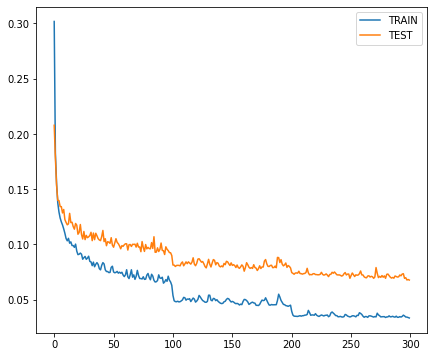

In [21]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [22]:
## testing

prediction = torch.zeros(ytest.shape).cuda()

counter = 0
print(f' TEST SET SHAPE :: {ytest.shape}')

with torch.no_grad():
    for x , y in test_loader:
      x,y = x.cuda(), y.cuda()
      out = model(x).reshape(batch_size,48,48,strain_channels)  #out.shape[batchsize, 48,48, channels]
      out = y_normalizer.decode(out)
      prediction[counter*batch_size: (counter*batch_size) + batch_size] = out
      counter+=1

 TEST SET SHAPE :: (200, 48, 48, 3)


In [23]:
zpred = toNumpy(prediction)[0]
ytest = toNumpy(y_test)[0]
xcor,ycor = getgrid(x_train)   ## numpy arrays
xtest = toNumpy(test_geo)[0]

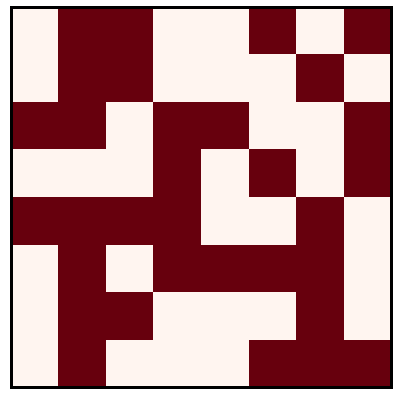

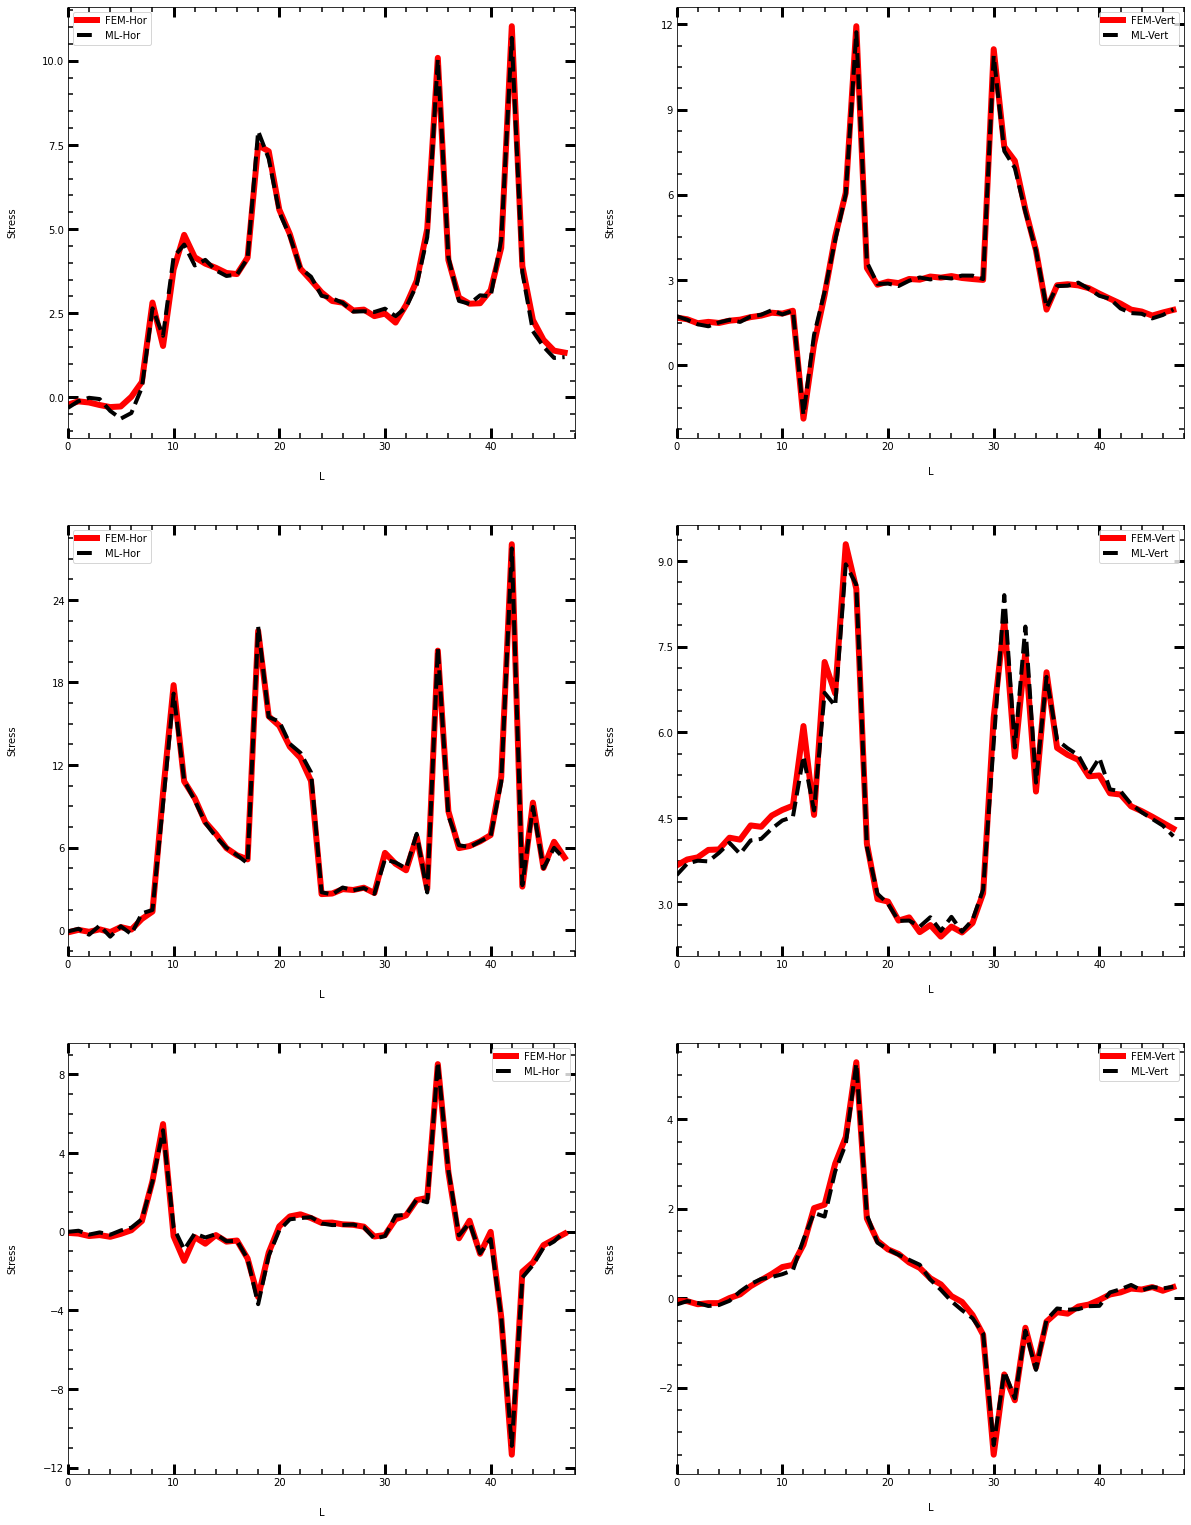

In [24]:
index=55
geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

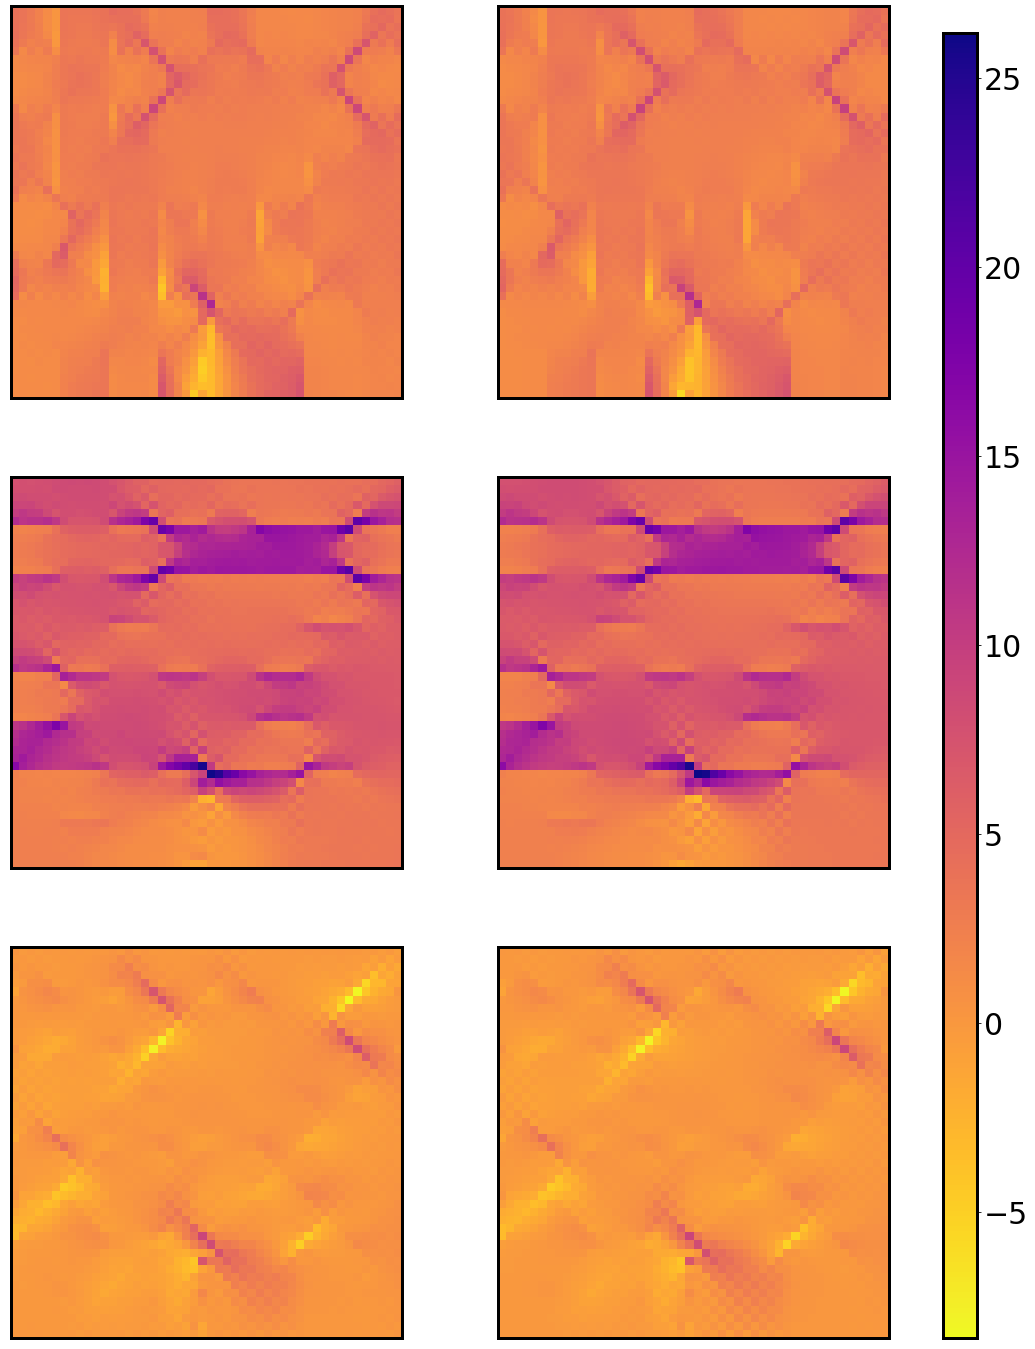

In [25]:
index =22
contour(ytest,zpred,xcor,ycor,index,cmap ='plasma_r')